**code for clustering and analyzing novel data**

In [8]:
%load_ext autoreload
%autoreload 2
#required packages
import os
import glob
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import pickle
from datetime import datetime
#need to run as administrator, otherwise takes too long
import umap
#my funcs
from ecog_functions import *

#inductive 
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils.metaestimators import available_if
from sklearn.utils.validation import check_is_fitted

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#PATHS AND GLOBAL VARIABLES
FEATURE_PATH = r'C:\Users\marty\Projects\sleep_new\res_temp\*'
UMAP_PATH = r'./models/umap_20231215162852_5rat4day.pkl'
INDUCTIVE_CL_PATH = r'./models/ind_20231219115111_5rat4day30cl.pkl'

In [10]:
#read saved feature paths
feat_paths=glob.glob(FEATURE_PATH)[:-3]
feat_paths

['C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20232905.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20233005.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20233105.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20232905.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20233005.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20233105.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20232905.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20233005.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20233105.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\14_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\14_20232905.pkl',
 'C:\\Users\\marty\\Projects\\slee

In [11]:
#load saved features
final_features=[]
for path in feat_paths:
    final_features.append(pickle.load(open(path,'rb')))
final_features=pd.concat(final_features)

<AxesSubplot: >

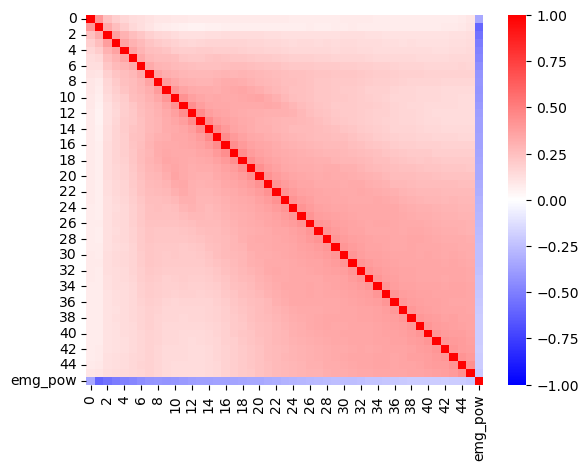

In [12]:
#check correlation
corr=final_features.corr()
sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1)

In [13]:
loaded_reducer=pickle.load(open(UMAP_PATH,'rb'))
loaded_reducer

UMAP(min_dist=0, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [14]:
#transform new data by umap
embedding=loaded_reducer.transform(final_features.values)

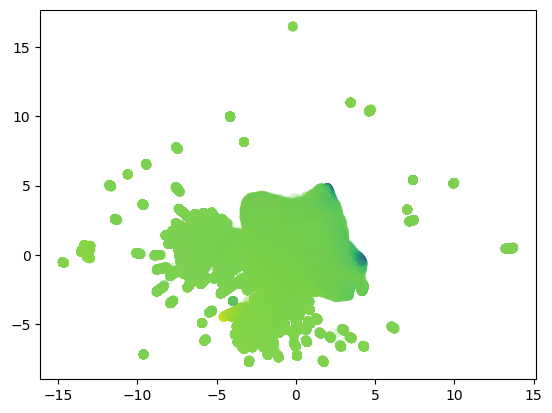

In [15]:
#sanity check - plot
plt.scatter(embedding[:,0],embedding[:,1], c=final_features['emg_pow'], alpha=0.1)

In [16]:
#load saved inductive classifier
#this is done because agglomerative clustering only works on ~80000 data points before running out of memory
#the inductive classifier is a random forest model trained on agglomerative clustering results
inductive_learner=pickle.load(open(INDUCTIVE_CL_PATH, 'rb'))

In [17]:
#get cluster predictions
final_features['cluster']=inductive_learner.predict(embedding)

c:\ProgramData\Anaconda3\envs\basicdata\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\basicdata\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


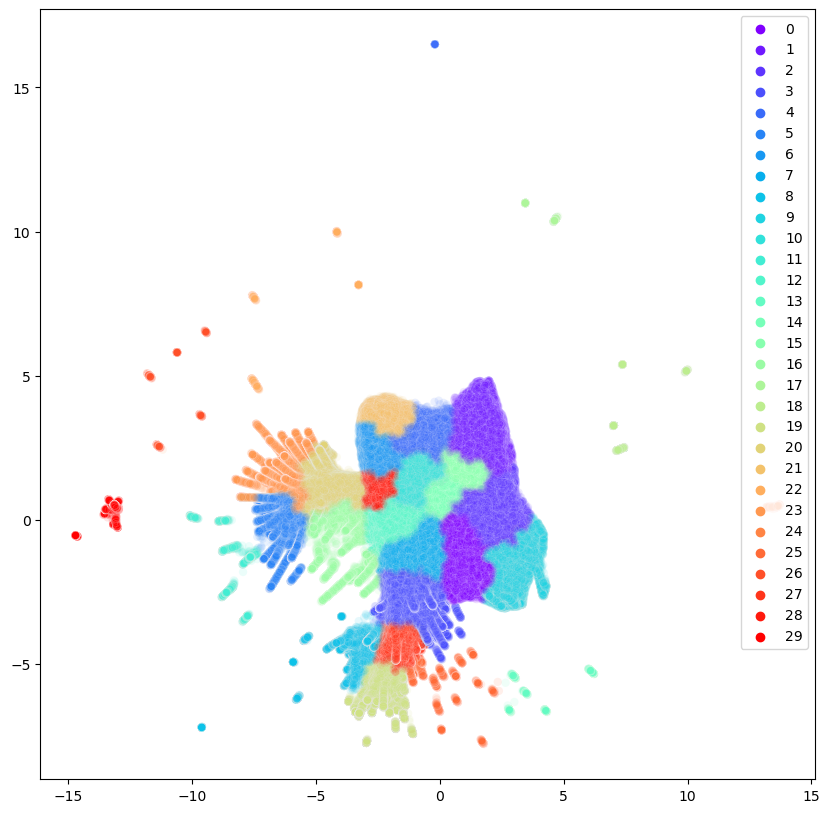

In [18]:
#plot resulting clusters
plt.subplots(figsize=(10,10))
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],hue=final_features['cluster'], alpha=0.1, palette='rainbow', legend='full')
plt.legend()

In [19]:
#define ranges of freq components for cluster sorting
delta=[str(x) for x in range(0,5)]
alpha=[str(x) for x in range(10,15)]
theta=[str(x) for x in range(4,8)]
beta=[str(x) for x in range(15,30)]
gamma=[str(x) for x in range(30,46)]

In [20]:
#create a df for sorting - sum values of each range of freqs in a given cluster
cl_sort_df=pd.DataFrame()
cl_sort_df['cluster']=final_features['cluster']
cl_sort_df['delta']=final_features[delta].sum(axis=1)
cl_sort_df['theta']=final_features[theta].sum(axis=1)
cl_sort_df['alpha']=final_features[alpha].sum(axis=1)
cl_sort_df['beta']=final_features[beta].sum(axis=1)
cl_sort_df['gamma']=final_features[gamma].sum(axis=1)
cl_sort_df['emg']=final_features['emg_pow']

In [21]:
#get rankings - sort clusters by each freq range power
delta_rankings=cl_sort_df.groupby('cluster').median().iloc[:,0].sort_values().index
theta_rankings=cl_sort_df.groupby('cluster').median().iloc[:,1].sort_values().index
alpha_rankings=cl_sort_df.groupby('cluster').median().iloc[:,2].sort_values().index
beta_rankings=cl_sort_df.groupby('cluster').median().iloc[:,3].sort_values().index
gamma_rankings=cl_sort_df.groupby('cluster').median().iloc[:,4].sort_values().index
emg_rankings=cl_sort_df.groupby('cluster').median().iloc[:,5].sort_values().index

In [22]:
#get a dataframe where row index is position (0 is the cluster that has the lowest values in selected freqs, 29 highest)
ranked = pd.DataFrame([delta_rankings,theta_rankings,alpha_rankings,beta_rankings,gamma_rankings,emg_rankings]).T
ranked.columns=cl_sort_df.columns[1:]
ranked

,delta,theta,alpha,beta,gamma,emg
0,29,29,8,29,29,9
1,8,8,29,8,19,1
2,19,19,9,19,27,2
3,27,27,19,9,8,0
4,3,25,27,27,3,14
5,25,3,25,3,9,4
6,17,13,3,25,25,15
7,13,9,13,0,7,20
8,12,12,0,7,13,10
9,7,17,12,13,0,23


In [23]:
#find W cluster(s)
#go through all clusters and check which ones have higher emg, beta or gamma index than others
#this is based on literature, as in W, gamma, beta and EMG should be higher
w_cls=[]
for cl in range(0,30):
    #check by emg
    if (np.where(ranked['emg']==cl)[0][0]>np.where(ranked['delta']==cl)[0][0])&(np.where(ranked['emg']==cl)[0][0]>np.where(ranked['theta']==cl)[0][0])&(np.where(ranked['emg']==cl)[0][0]>np.where(ranked['alpha']==cl)[0][0]):
        w_cls.append(cl)
    #check by beta
    elif (np.where(ranked['beta']==cl)[0][0]>np.where(ranked['delta']==cl)[0][0])&(np.where(ranked['beta']==cl)[0][0]>np.where(ranked['theta']==cl)[0][0])&(np.where(ranked['beta']==cl)[0][0]>np.where(ranked['alpha']==cl)[0][0]):
        w_cls.append(cl)
    #check by gamma
    elif (np.where(ranked['gamma']==cl)[0][0]>np.where(ranked['delta']==cl)[0][0])&(np.where(ranked['gamma']==cl)[0][0]>np.where(ranked['theta']==cl)[0][0])&(np.where(ranked['gamma']==cl)[0][0]>np.where(ranked['alpha']==cl)[0][0]):
        w_cls.append(cl)

#found candidates
w_cls

[3, 4, 6, 7, 8, 12, 13, 17, 18, 19, 21, 25, 27, 28, 29]

In [24]:
#find NREM cluster(s)
#go through all clusters and check which ones have higher delta or alpha index others
#same but with high delta/alpha
nrem_cls=[]
for cl in range(0,30):
    #check by delta
    if (np.where(ranked['delta']==cl)[0][0]>np.where(ranked['theta']==cl)[0][0])&(np.where(ranked['delta']==cl)[0][0]>np.where(ranked['emg']==cl)[0][0])&(np.where(ranked['delta']==cl)[0][0]>np.where(ranked['gamma']==cl)[0][0])&(np.where(ranked['delta']==cl)[0][0]>np.where(ranked['beta']==cl)[0][0]):
        if cl not in w_cls:
            nrem_cls.append(cl)
    #check by alpha
    elif (np.where(ranked['alpha']==cl)[0][0]>np.where(ranked['theta']==cl)[0][0])&(np.where(ranked['alpha']==cl)[0][0]>np.where(ranked['emg']==cl)[0][0])&(np.where(ranked['alpha']==cl)[0][0]>np.where(ranked['gamma']==cl)[0][0])&(np.where(ranked['alpha']==cl)[0][0]>np.where(ranked['beta']==cl)[0][0]):
        if cl not in w_cls:
            nrem_cls.append(cl)

#found candidates
nrem_cls

[0, 5, 9, 11, 15, 20, 22, 23, 24, 26]

In [25]:
#find REM cluster(s)
#go through all clusters and check which ones have higher theta index than delta and emg
rem_cls=[]
for cl in range(0,30):
    if (np.where(ranked['theta']==cl)[0][0]>np.where(ranked['delta']==cl)[0][0])&(np.where(ranked['theta']==cl)[0][0]>np.where(ranked['emg']==cl)[0][0]):
        if cl not in w_cls and cl not in nrem_cls:
            rem_cls.append(cl)
#found candidates
rem_cls 
#for rem, additional check is needed, since it should only provide 1 cluster (because REM is very specific and takes around 5% of the day)
#emg must be non-existent, the defining feature of REM
#select that which has lowest emg index - most suitable
for cl in rem_cls:
    final_cl_pos=29
    final_cl=0
    if np.where(ranked['emg']==cl)[0][0]<final_cl_pos:
        final_cl=cl
print(final_cl)

14


In [27]:
#add this to feature df
final_features['sleep']=np.NaN
final_features['sleep'][final_features['cluster'].isin(w_cls)] = 'W'
final_features['sleep'][final_features['cluster'].isin(nrem_cls)] = 'NREM'
final_features['sleep'][final_features['cluster']==final_cl] = 'REM'#

C:\Users\marty\AppData\Local\Temp\ipykernel_12068\4266634048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features['sleep'][final_features['cluster'].isin(w_cls)] = 'W'


In [28]:
#some clusters are left unknown
unknown_cls = np.unique(final_features[final_features['sleep']==np.NaN]['cluster'])
unknown_cls

array([], dtype=int64)

In [38]:
#temporal separation - select most common state in set s to drop a bit of noise
integration_s=10
res_sleep=[]
#nans bfilled - should figure out a better method, ran out of time
raw_sleep=final_features['sleep'].reset_index(drop=True).fillna(method='bfill')
for i in tqdm(range(0, len(raw_sleep)-integration_s)):
    #take most common value in 5s if it exists (not NaN)
    mode = raw_sleep[i:i+integration_s].mode()[0]
    #print(mode)
    if mode !=0:
        res_sleep.append(mode[0])
    else:
        print('weird error, mode=0')

100%|██████████| 1519703/1519703 [01:39<00:00, 15300.01it/s]


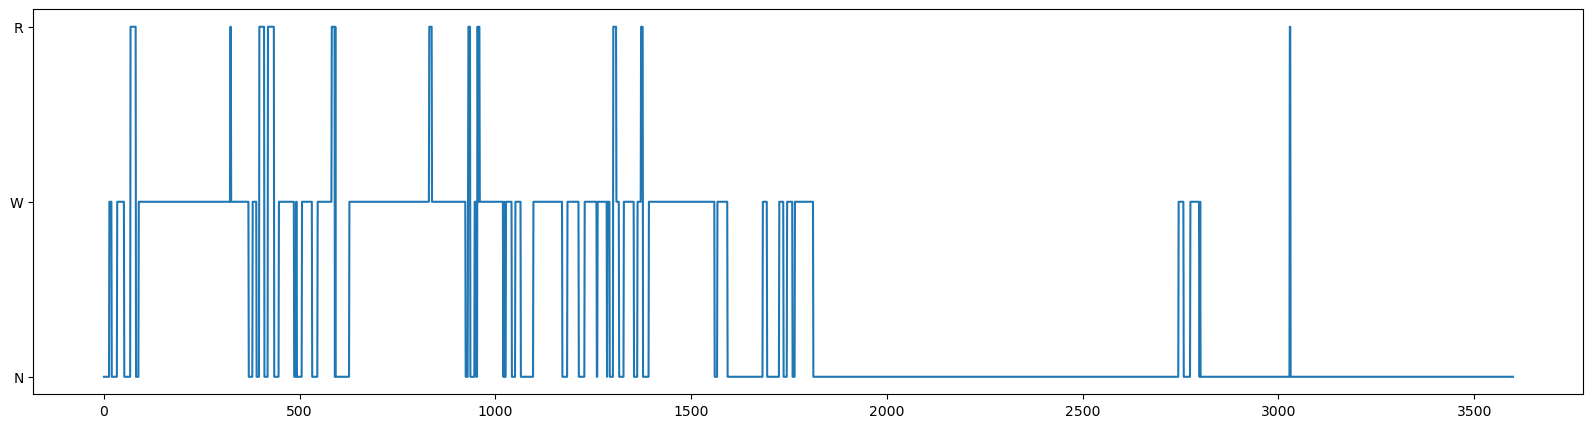

In [46]:
#plot one hour
plt.subplots(figsize=(20,5))
plt.plot(res_sleep[2000:5600])

In [40]:
# #rolling median to for smoothing
# pd.Series(res_sleep).rolling(5).median()

In [41]:
#sanity check - how much of data has been classified as what
np.unique(res_sleep, return_counts=True)

(array(['N', 'R', 'W'], dtype='<U1'),
 array([580700,  36304, 902699], dtype=int64))

In [42]:
#looks correctish!
np.unique(res_sleep, return_counts=True)[1]/len(res_sleep)

array([0.38211414, 0.02388888, 0.59399698])

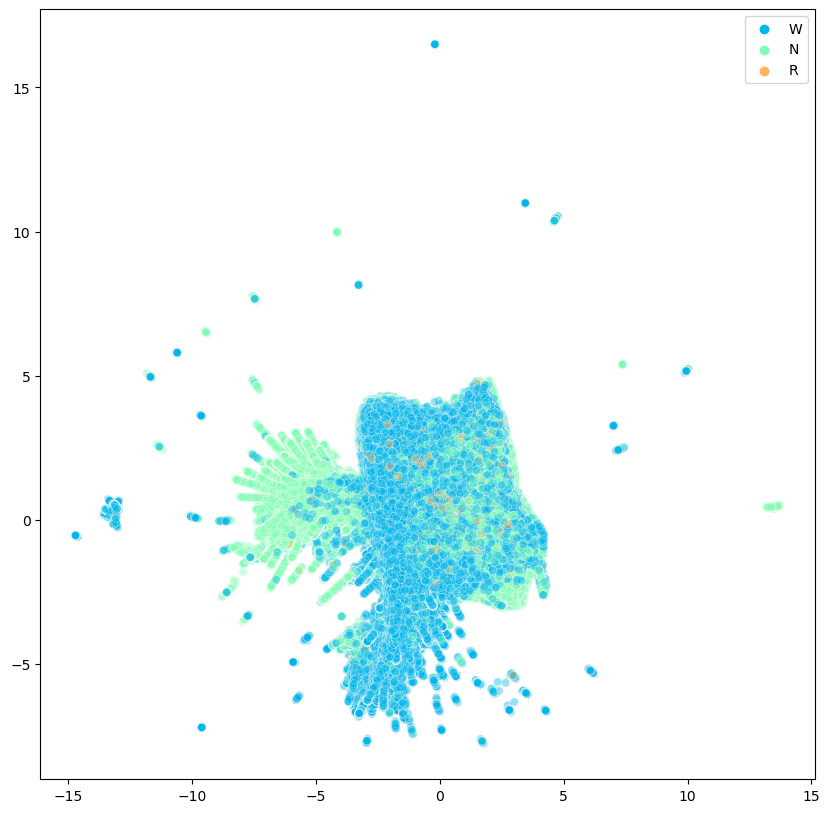

In [45]:
#plot umap colored as sleep states
plt.subplots(figsize=(10,10))
sns.scatterplot(x=embedding[:,0][:-integration_s],y=embedding[:,1][:-integration_s],hue=res_sleep, alpha=0.4, palette='rainbow', legend='full')
plt.legend()